In this section we are going to use a machine learning technique called random forest, which is able to use multiple elements simultaneously to calibrate a thermobarometer.

To do this we can use "packages" in R, which are open source packages designed to perform certain tasks. There are a lot of packages: https://cran.r-project.org/web/packages/available_packages_by_name.html

These packages can be installed using the following command:
install.packages("*package name*", dependencies=TRUE)

Then each time you open R, they have to be individually opened using the command "library()"

In [61]:
library(PerformanceAnalytics)
library(randomForest)
library(PeriodicTable)

In [62]:
df <- read.table("CPX_experiments.txt",sep="\t",header=TRUE)
df[is.na(df)]<-0

Like before, we can subset the dataset for temperature and pressure

In [63]:
ID <- which(df$T_K > 700 & df$P_GPa > 0 & (df$Na2O.liq+df$K2O.liq) < 6) 
df <- df[ID,]

We can do a further check of the experiments, to only include those who have good analyses, based on the number of cations.

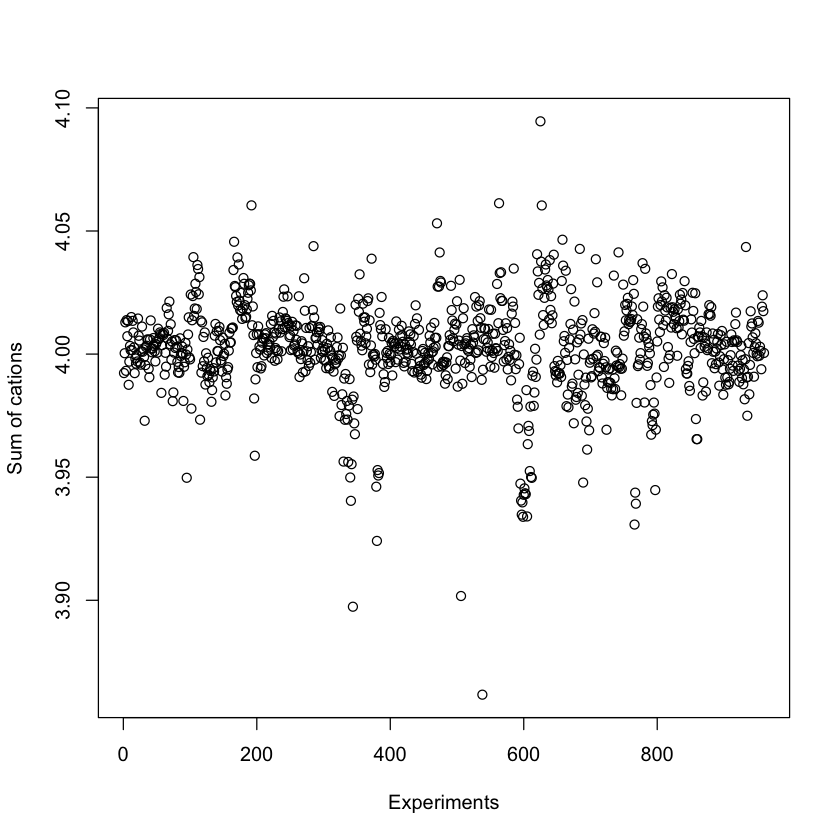

In [64]:
df_m_Si<- df$SiO2.cpx/(mass("Si")+(mass("O")*2))
df_m_Ti<- df$TiO2.cpx/(mass("Ti")+(mass("O")*2))
df_m_Al<- (df$Al2O3.cpx/((mass("Al")*2)+(mass("O")*3)))*2
df_m_Fe<- df$FeOt.cpx/(mass("Fe")+mass("O"))
df_m_Mn<- df$MnO.cpx/(mass("Mn")+(mass("O")))
df_m_Mg<- df$MgO.cpx/(mass("Mg")+(mass("O")))
df_m_Ca<- df$CaO.cpx/(mass("Ca")+(mass("O")))
df_m_Na<- (df$Na2O.cpx/((mass("Na")*2)+(mass("O"))))*2

oxygens<- df_m_Si*2+df_m_Ti*2+(df_m_Al/2)*3+df_m_Fe+df_m_Mn+df_m_Mg+df_m_Ca+df_m_Na/2
n.O<- 6 #Number of oxigen ofr recaclulation 
factor<- n.O/oxygens
Si_apfu<- df_m_Si*factor
Ti_apfu<- df_m_Ti*factor
Al_apfu<- df_m_Al*factor
Fe_apfu<- df_m_Fe*factor
Mn_apfu<- df_m_Mn*factor
Mg_apfu<- df_m_Mg*factor
Ca_apfu<- df_m_Ca*factor
Na_apfu<- df_m_Na*factor

sum.cations<- Si_apfu+ Ti_apfu+ Al_apfu+ Fe_apfu+ Mn_apfu+ Mg_apfu+ Ca_apfu+ Na_apfu
plot(sum.cations,xlab="Experiments",ylab="Sum of cations")


So, now we can remove the experiments where cpx cations do not add up to 4

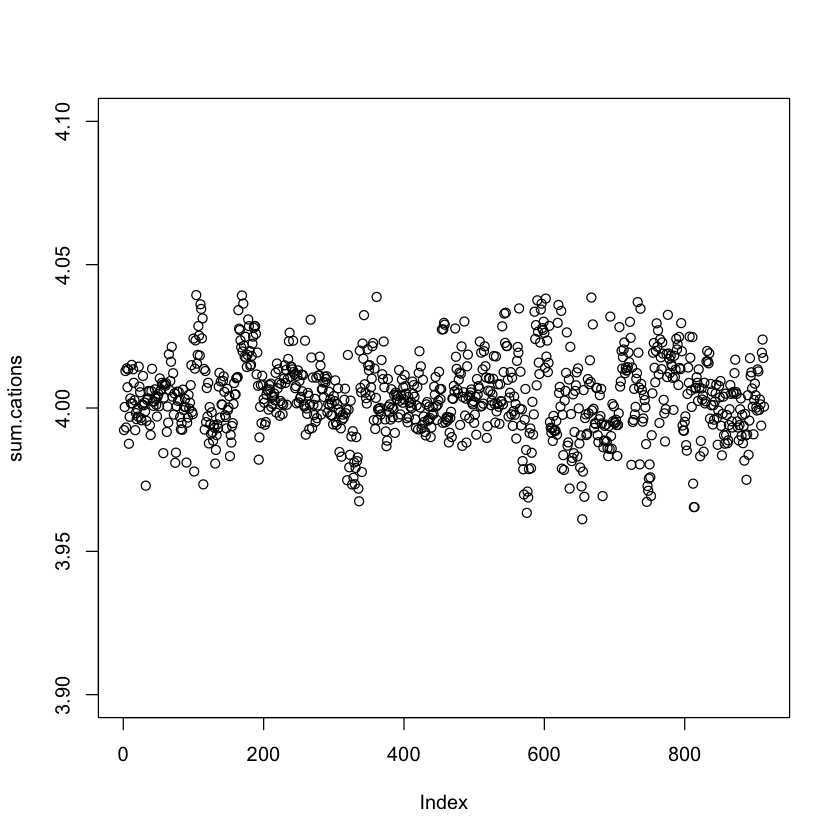

In [65]:
ID.remove.2<- which(sum.cations>4.04 | sum.cations<3.96)
df<- df[-c(ID.remove.2),]
sum.cations<- sum.cations[-c(ID.remove.2)]
plot(sum.cations, ylim=c(3.9, 4.1))

Next, we define the parameters of the random forest:

In [66]:
n.exp<- nrow(df) #Number of experiments
f.train<- 0.7 #Fraction used for training
f.validation<- 0.2 #Fraction used for Validation
f.test<- 0.1 #Fraction used for testing

The data are ordered to select Validation and test dataset spanning the entire P or T range (either P_GPa or T_K):

In [67]:
ID.ordered<- order(df$P_GPa, decreasing = FALSE)
n.test<- floor(n.exp*f.test) 
ID.test<- sample(ID.ordered, floor(n.test/2), replace = FALSE)
TestSet<- df[ID.test,]
ID.train.validation<- ID.ordered[-c(ID.test)]

Hyperparameter tuning:

Within the following loop a different split is prepared of the Train and Validation dataset for hyperparameter tuning and to test the performance of the algorithm on the test dataset.

You need to choose the number of repetitions!

In [68]:
nr<- 10 #Number of repetitions
n.trees<- seq(10, 1000, length.out = nr) #Number of trees used in each training phase
n.elements<- seq(2, 10, by=1) #NNumber of features (i.e. oxides) used in each training phase

SEE.Valid_P.cpx<-NULL
SEE.Valid_T.cpx<-NULL
SEE.Test_P.cpx<-NULL
SEE.Test_T.cpx<-NULL
n.elements_sel<- NULL
for (i in 1: nr){
  ID.train<- sample(ID.train.validation, ceiling(length(ID.train.validation)*0.8), replace = FALSE)
  ID.validation<- ID.train.validation[-c(ID.train)]
  TrainSet<- df[ID.train,]
  ValidSet<- df[ID.validation,]
  n.elements_sel[i]<- sample(seq(2,8,1), 1, replace = FALSE) #Selected number of elements
  model_P.cpx <- randomForest(TrainSet$P_GPa ~ ., 
                              data = TrainSet[,c("SiO2.cpx","TiO2.cpx","Al2O3.cpx","Cr2O3.cpx","FeOt.cpx","MnO.cpx","MgO.cpx","CaO.cpx","Na2O.cpx")], 
                              ntree=n.trees[i], mtry=n.elements_sel[i])
  model_T.cpx<- randomForest(TrainSet$T_K ~ ., 
                             data = TrainSet[,c("SiO2.cpx","TiO2.cpx","Al2O3.cpx","Cr2O3.cpx","FeOt.cpx","MnO.cpx","MgO.cpx","CaO.cpx","Na2O.cpx")], 
                             ntree=n.trees[i], mtry=n.elements_sel[i])
  
  predValid_P.cpx <- as.vector(predict(model_P.cpx, newdata = ValidSet[,c("SiO2.cpx","TiO2.cpx","Al2O3.cpx","Cr2O3.cpx","FeOt.cpx","MnO.cpx","MgO.cpx","CaO.cpx","Na2O.cpx")]))
  SEE.Valid_P.cpx[i]<- (sum((predValid_P.cpx-ValidSet$P_GPa)^2)/length(ValidSet$P_GPa))^(0.5)
  predValid_T.cpx <- as.vector(predict(model_T.cpx, newdata = ValidSet[,c("SiO2.cpx","TiO2.cpx","Al2O3.cpx","Cr2O3.cpx","FeOt.cpx","MnO.cpx","MgO.cpx","CaO.cpx","Na2O.cpx")]))
  SEE.Valid_T.cpx[i]<- (sum((predValid_T.cpx-ValidSet$T_K)^2)/length(ValidSet$T_K))^(0.5)
  
  predTest_P.cpx <- as.vector(predict(model_P.cpx, newdata = TestSet[,c("SiO2.cpx","TiO2.cpx","Al2O3.cpx","Cr2O3.cpx","FeOt.cpx","MnO.cpx","MgO.cpx","CaO.cpx","Na2O.cpx")]))
  SEE.Test_P.cpx[i]<- (sum((predTest_P.cpx-TestSet$P_GPa)^2)/length(TestSet$P_GPa))^(0.5)
  predTest_T.cpx <- as.vector(predict(model_T.cpx, newdata = TestSet[,c("SiO2.cpx","TiO2.cpx","Al2O3.cpx","Cr2O3.cpx","FeOt.cpx","MnO.cpx","MgO.cpx","CaO.cpx","Na2O.cpx")]))
  SEE.Test_T.cpx[i]<- (sum((predTest_T.cpx-TestSet$T_K)^2)/length(TestSet$T_K))^(0.5)
}
print("Finished")

[1] "Finished"


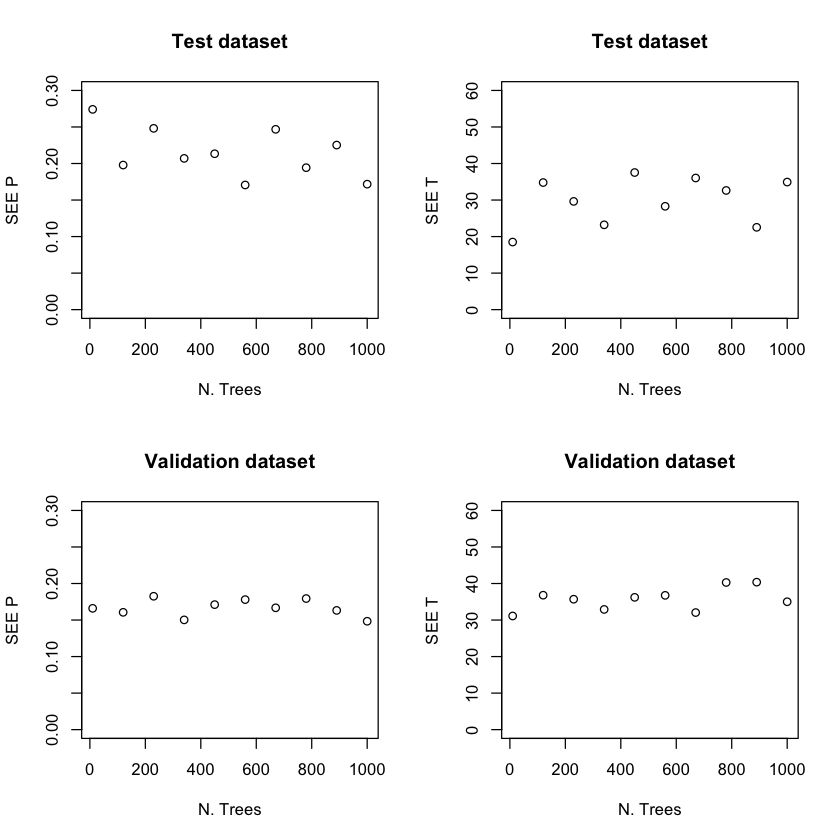

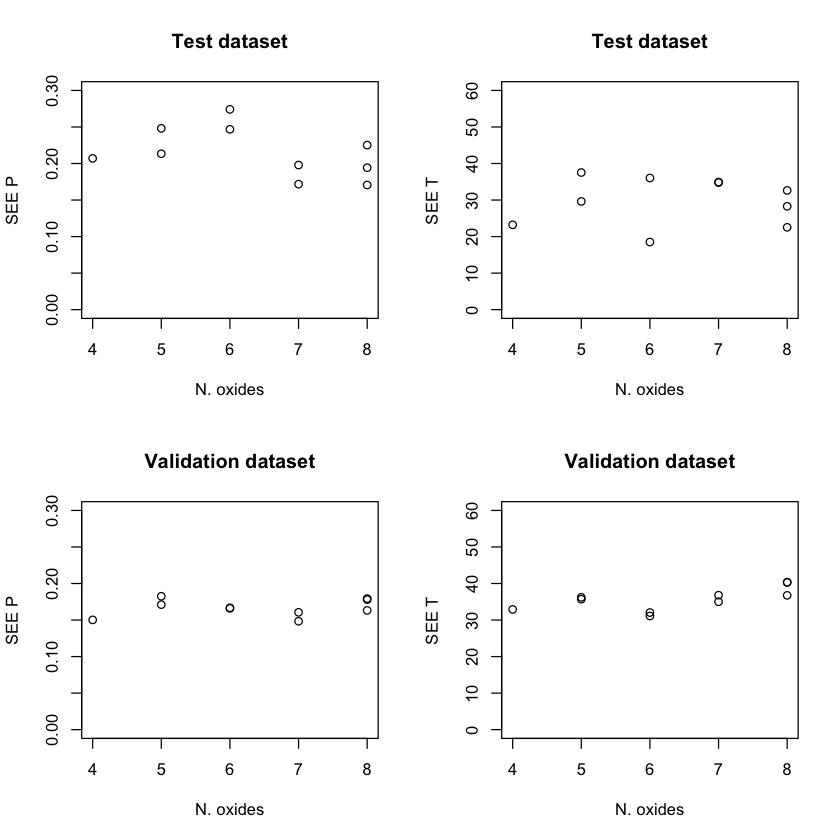

In [69]:
par(mfrow=c(2,2))
plot(n.trees, SEE.Test_P.cpx, ylim=c(0, 0.3), main="Test dataset", ylab="SEE P", xlab="N. Trees")
plot(n.trees, SEE.Test_T.cpx, ylim=c(0, 60), main="Test dataset", ylab="SEE T", xlab="N. Trees")
plot(n.trees, SEE.Valid_P.cpx, ylim=c(0, 0.3), main="Validation dataset", ylab="SEE P", xlab="N. Trees")
plot(n.trees, SEE.Valid_T.cpx, ylim=c(0, 60), main="Validation dataset", ylab="SEE T", xlab="N. Trees")
par(mfrow=c(1,1))

par(mfrow=c(2,2))
plot(n.elements_sel, SEE.Test_P.cpx, ylim=c(0, 0.3), main="Test dataset", ylab="SEE P", xlab="N. oxides")
plot(n.elements_sel, SEE.Test_T.cpx, ylim=c(0, 60), main="Test dataset", ylab="SEE T", xlab="N. oxides")
plot(n.elements_sel, SEE.Valid_P.cpx, ylim=c(0, 0.3), main="Validation dataset", ylab="SEE P", xlab="N. oxides")
plot(n.elements_sel, SEE.Valid_T.cpx, ylim=c(0, 60), main="Validation dataset", ylab="SEE T", xlab="N. oxides")
par(mfrow=c(1,1))

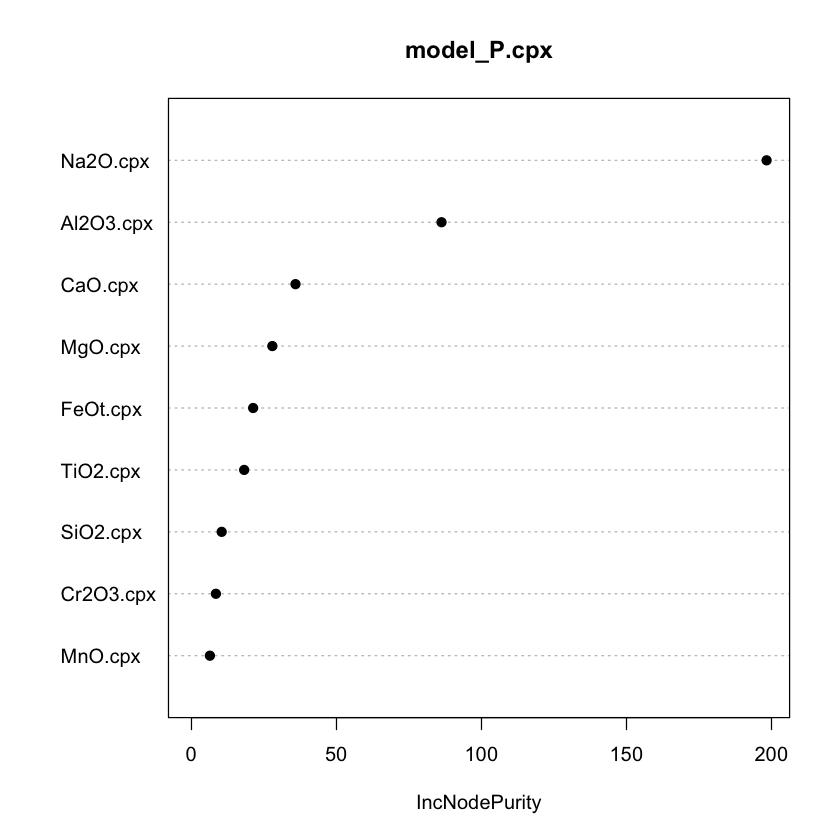

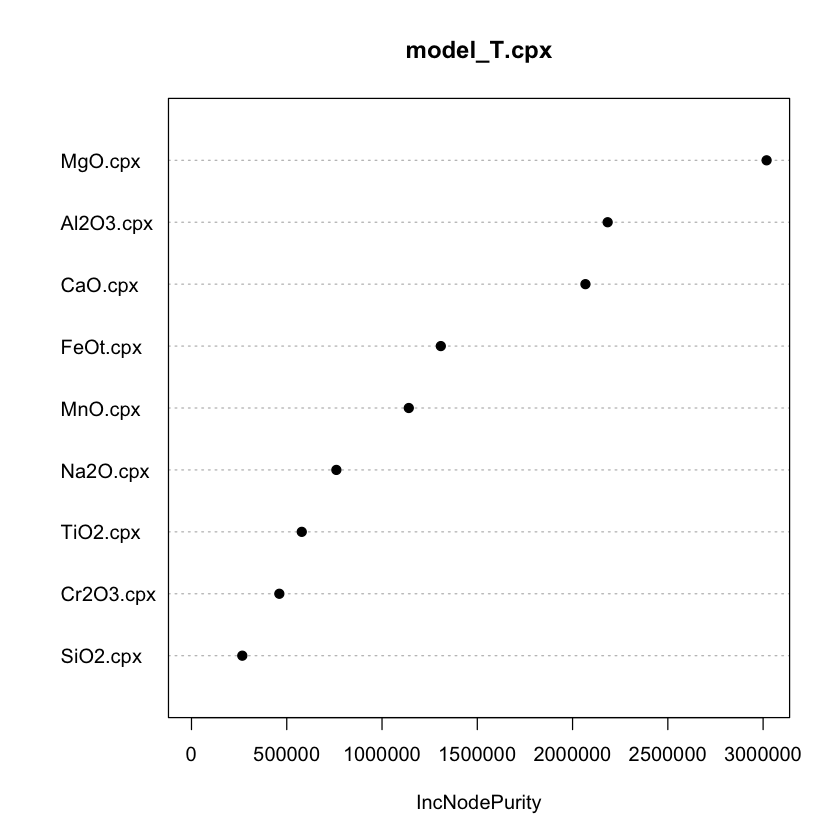

In [70]:
varImpPlot(model_P.cpx, sort = TRUE, pch=19)
varImpPlot(model_T.cpx, sort = TRUE, pch=19)

In [90]:
#measured.chem <- read.table("cpx_bardabunga.txt",sep="\t",header=TRUE)
measured.chem <- read.table("cpx_etna.txt",sep="\t",header=TRUE)

measured.chem <- data.frame(measured.chem[,3:12])
colnames(measured.chem) <- paste0(colnames(measured.chem),".cpx")

,SiO2.cpx,TiO2.cpx,Al2O3.cpx,FeOt.cpx,MnO.cpx,MgO.cpx,CaO.cpx,Na2O.cpx,Cr2O3.cpx,NiO.cpx
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,47.63,NA,6.74,11.39,0.21,12.90,20.87,NA,NA,NA
2,48.59,1.62,5.06,8.53,0.19,12.56,22.39,0.97,NA,NA
3,46.54,2.32,6.17,8.95,0.17,12.54,21.97,0.80,NA,NA
4,49.67,1.04,4.61,4.78,0.01,15.00,23.49,0.35,0.24,NA
5,50.74,0.87,5.29,5.43,0.12,14.84,23.15,0.37,0.16,NA
6,49.77,1.00,4.83,5.69,0.16,14.93,23.28,0.35,0.21,NA


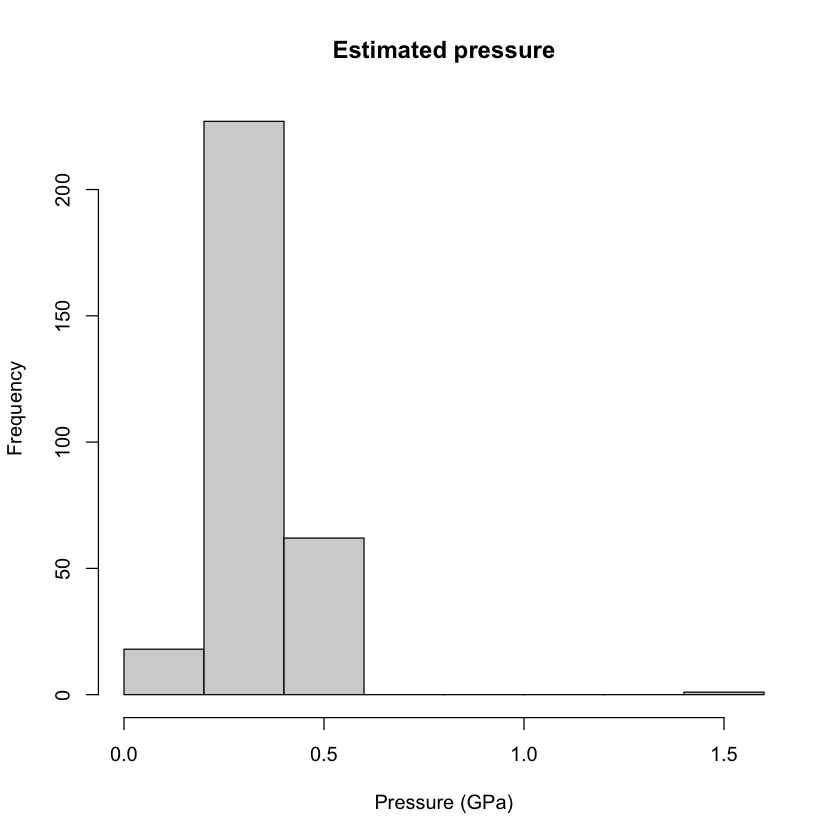

In [91]:
est <- as.vector(predict(model_P.cpx, newdata = measured.chem))
hist(est, main = "Estimated pressure", xlab="Pressure (GPa)")

Now we can look at the different eruptions, to understand the avriation in pressure:
1. "AD 1669"
2. "AD 1974"
3. "AD 2002"
4. "feb 2021"

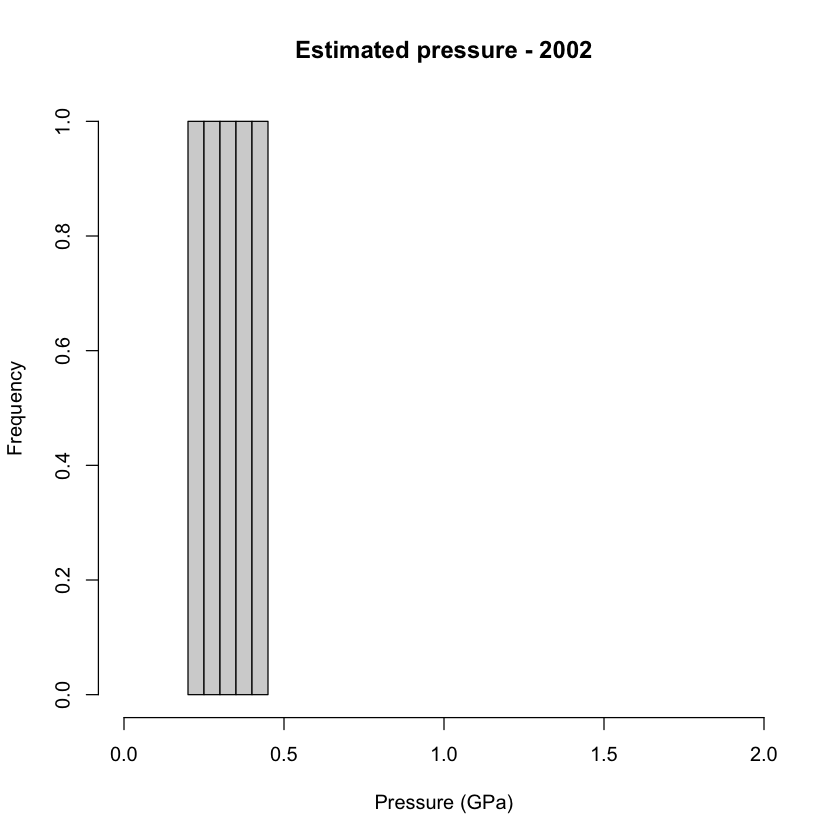

In [106]:
etna <- read.table("cpx_etna.txt",sep="\t",header=TRUE)

eruption.id <- grep(etna$Eruption,pattern = "AD 1669")
eruption <- etna[eruption.id,]
eruption <- data.frame(eruption[,3:12])
colnames(eruption) <- paste0(colnames(eruption),".cpx")
est <- as.vector(predict(model_P.cpx, newdata = eruption))
hist(est, main = "Estimated pressure - 2002", xlab="Pressure (GPa)",xlim=c(0,2))